# Import Libraries and Load Data

In [1]:
# import sklearn
!pip install plydata
!pip install plotnine
!pip install hyperopt


import pandas as pd
import numpy as np
from plydata import *
from plotnine import *
from hyperopt import hp, tpe, fmin
from joblib import dump,load
import pickle

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 307kB 2.5MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import the scored data. 
all_scored = pd.read_csv('/content/drive/My Drive/5_datascience/2_context_chatbot/data/graded/all_graded_with_scores.csv')

# Preprocessing: Check for missing data and split the data

In [0]:
# Drop any rows where the label is NA.  
all_scored_full = all_scored[all_scored['NCJ_Rating'].notnull()] # Ask Jacobson about this. 

# Split the data into features and labels. 
X = all_scored_full >> select('-input','-output_list', '-NCJ_Rating')
X = X.reindex(sorted(X.columns), axis=1)
y = all_scored_full['NCJ_Rating']

In [0]:
print(X.shape)

print(y.shape)

(12900, 786)
(12900,)


In [0]:
# Split into a 66/33 training-test set. 
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size= .2)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [0]:
pickle.dump(scaler, open('/content/drive/My Drive/5_datascience/2_context_chatbot/data/models/scaler.p', "wb"))

# Training the Models

## Using sklearn defaults and 5 fold cross validation

In [0]:
scores = ['neg_mean_squared_error']
rf = RandomForestRegressor(verbose=0)
rf_cv_result = cross_validate(rf, X_train_scaled, y_train, cv=5, scoring=scores, return_estimator=True)
rf_cv_result

{'estimator': (RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None, oob_score=False,
                        random_state=None, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None, oob_score=False,
                        random_state

In [0]:
# Dump the random forest classifier as a saved model
dump(rf_cv_result['estimator'][4], '/content/drive/My Drive/5_datascience/2_context_chatbot/data/models/default_rf.joblib')

['/content/drive/My Drive/5_datascience/2_context_chatbot/data/models/default_rf.joblib']

In [0]:
xgb = GradientBoostingRegressor()
xgb_cv_result = cross_validate(xgb, X_train, y_train, cv=5, scoring=scores, return_estimator=True)
xgb_cv_result

{'fit_time': array([27.99653912, 27.85759664, 28.89443803, 33.82636786, 34.08112884]),
 'score_time': array([0.00983548, 0.00997639, 0.00996566, 0.01006532, 0.00982594]),
 'test_max_error': array([-8.36459065, -8.50526404, -8.52169761, -8.3873781 , -8.52516806]),
 'test_neg_mean_squared_error': array([-3.46825741, -3.4290645 , -3.40397756, -3.50296426, -3.3547706 ])}

In [0]:
lr = LinearRegression()
lr_cv_result = cross_validate(lr, X_train, y_train, cv=3, scoring=scores)
lr_cv_result

{'fit_time': array([0.49864912, 0.45391178, 0.4492259 ]),
 'score_time': array([0.00481582, 0.00391436, 0.00396705]),
 'test_max_error': array([-2.76179672e+10, -6.76926276e+10, -2.99344902e+10]),
 'test_neg_mean_squared_error': array([-2.65984023e+17, -1.68022992e+18, -4.16698606e+17])}

## Bayesian Hyperparameter Optimization

In [0]:
def objective_function(params):
    """Objective function to minimize:  -MSE"""
    
    model_name = params['model']  # Gets the model name
    del params['model'] # Deletes model name, rest of params are hyperparameters
    
    # Initialize model with parameters
    if model_name == "RandomForestRegressor":
        model = RandomForestRegressor(**params)
    elif model_name == "GradientBoostingRegressor":
        model = GradientBoostingRegressor(**params)

    elif model_name == "LinearRegression":
        model = LinearRegression(**params)
  
    
    
    scores = ['neg_mean_squared_error','max_error']
    
    cv_scores = cross_validate(model, X, y, cv=5, scoring = scores, )

    cv_neg_MSE = np.mean(cv_scores['test_neg_mean_squared_error'])

    return -cv_neg_MSE


def get_space(model):
    model_name = type(model).__name__
    print(model_name)


    if model_name == "RandomForestRegressor":
        space_dict = {'model' : model_name,
                      'max_depth': hp.choice('max_depth', range(1,1000000000)),
                      'max_features': hp.choice('max_features', range(1,1000000000)),
                      'n_estimators': hp.choice('n_estimators', range(1,1000000000))}

    elif model_name == "GradientBoostingRegressor":
        space_dict = {'model' : model_name,
                      'max_depth': hp.choice('max_depth', range(1,50)),
                      'n_estimators': hp.choice('n_estimators', range(1,100))}
    
    return space_dict

        

In [0]:
rf = RandomForestRegressor()
lr = LinearRegression()
xgb = GradientBoostingRegressor()

model_list = [rf]

for model in model_list:
  space = get_space(model)

  best_h = fmin(fn=objective_function, space=space, algo=tpe.suggest, max_evals=10)
  

In [0]:
np.isinf(X_train).sum()

In [0]:
pd.DataFrame(X_train).isna().sum().sum()

0

In [0]:
np.isinf(y_train).sum()

0

In [0]:
pd.DataFrame(y_train).isna().sum().sum()

4

# Test Set 

In [0]:
default_rf = load('/content/drive/My Drive/5_datascience/2_context_chatbot/data/models/default_rf.joblib')

In [0]:
rf_pred = default_rf.predict(X_test)
mean_squared_error(y_test, rf_pred)

1.4740279444390108

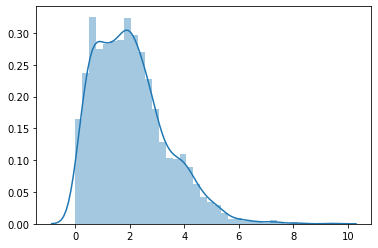

In [0]:
sns.distplot(rf_pred)

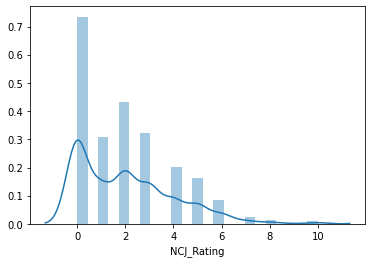

In [0]:
sns.distplot(y_test)

In [0]:
import scipy

In [0]:
test_obj = pd.DataFrame([y_test, rf_pred])
test_obj

,9116,4016,3027,11022,6031,284,2530,4145,6734,12290,10239,4770,2335,10254,6985,12897,8324,1887,7027,6133,8267,3085,10958,6235,12225,676,6176,12873,3373,3112,5,6910,12127,7350,896,717,9612,10046,8790,2261,...,11101,12514,11092,2166,573,7506,8881,12894,6920,6707,1529,5402,4794,8504,2723,12699,12874,6982,12026,4091,5151,5391,6867,2773,8239,4578,5526,7356,8795,2409,11610,11171,5013,7,5214,5422,2240,683,3330,7494
NCJ_Rating,1.0,5.0,1.0,1.0,0.0,2.00,1.000000,4.0,2.0,0.0,5.0,0.0,5.00,0.0,5.0,0.0,2.0,6.000000,3.0,2.0,0.0,3.0,3.0,4.0,0.0,3.00,0.0,2.0,0.0,1.0,4.00,0.0,3.0,0.0,4.00,2.000,3.0,0.0,0.0,2.00,...,1.0,0.0,0.0,5.0,7.000,1.0,3.0,2.0,3.0,2.0,0.00,3.0,0.0,0.0,0.0,3.0,3.0,0.0,6.0,5.0,2.0,6.0,1.0,1.0,2.0,0.0,0.0,2.0,2.0,2.00,0.0,4.0,0.0,2.00,3.0,0.0,2.00,2.00,9.0,2.0
Unnamed 0,NaN,NaN,NaN,NaN,NaN,1.06,2.228571,NaN,NaN,NaN,NaN,NaN,4.33,NaN,NaN,NaN,NaN,1.106667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.75,NaN,NaN,NaN,NaN,1.88,NaN,NaN,NaN,2.45,1.635,NaN,NaN,NaN,0.49,...,NaN,NaN,NaN,2.1,1.825,NaN,NaN,NaN,NaN,NaN,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.67,NaN,NaN,NaN,2.65,NaN,NaN,1.84,2.01,NaN,NaN


In [0]:
pd.Series(rf_pred).isna().sum()


dataset=pd.DataFrame({"y_test":y_test,"rf_pred":rf_pred},columns=["y_test","rf_pred"])
dataset 

,y_test,rf_pred
9116,1,1.006667
4016,5,5.420000
3027,1,1.480000
11022,1,1.230000
6031,0,1.310000
...,...,...
5422,0,0.610000
2240,2,1.903524
683,2,3.476500
3330,9,1.560000


In [0]:
ss = dataset.loc[dataset['y_test'] >= 5,]
ss

,y_test,rf_pred
4016,5,5.420000
10239,5,4.450000
2335,5,4.100000
6985,5,1.463333
1887,6,4.760000
...,...,...
573,7,5.910000
12026,6,1.790000
4091,5,4.220000
5391,6,4.640000


In [0]:
from scipy import stats
stats.spearmanr(ss) # implement a spearmanr with a threshold for the minimum NCJ rating.

SpearmanrResult(correlation=0.4171944969374205, pvalue=1.2661476312563283e-15)

In [0]:
stats.spearmanr(dataset)

SpearmanrResult(correlation=0.7908104642158417, pvalue=0.0)